## Imports

In [38]:
%autoreload
from collections import defaultdict
import itertools
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import Predictive, SVI, Trace_ELBO, TraceGraph_ELBO, config_enumerate
from pyro import poutine
from pyro.optim import Adam
import gpytorch as gp
from gpytorch.kernels import RBFKernel, PeriodicKernel, ScaleKernel, ProductKernel, LinearKernel, AdditiveKernel
import visdom
import pdb
from pmextract import extract
import matplotlib.pyplot as plt
import autostat as a

In [2]:
leaf_name = "param " + str(a.hash_prog(a.Prog()))

In [3]:
LOGRATE = 20

In [4]:
vis = visdom.Visdom(env='nb')

Setting up a new session...


## Fake Data

In [5]:
p = a.Prog()

In [6]:
p.adds.add(frozenset([PeriodicKernel, RBFKernel]))
p.adds.add(frozenset([LinearKernel]))

In [7]:
k = a.to_kernel(p)

In [8]:
x = (torch.arange(100) / 40)

In [9]:
x1 = x[:50, None]

In [10]:
x2 = x[50:, None]

In [11]:
MEAN = gp.means.ZeroMean()

In [12]:
fancy_y = a.gp_model(a.Prog(), MEAN, k, x1, None).detach()

/home/sam/.local/lib/python3.10/site-packages/gpytorch/utils/cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/sam/.local/lib/python3.10/site-packages/gpytorch/lazy/lazy_tensor.py:1741: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  /build/python-pytorch/src/pytorch-1.11.0/aten/src/ATen/native/BatchLinearAlgebra.cpp:1666.)
  Linv = torch.triangular_solve(Eye, L, upper=False).solution


In [13]:
with torch.no_grad():
    fancy_y2 = k(x2, x1) @ k(x1).add_diag(torch.tensor(0.001)).inv_matmul(fancy_y)

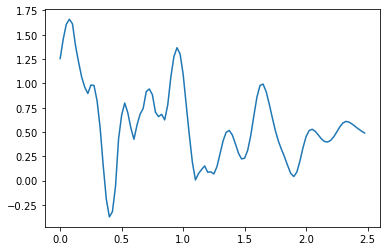

In [14]:
plt.plot(x, torch.cat((fancy_y, fancy_y2)))

## Greedy Training

In [31]:
KERNS = {}

In [53]:
def full_model():
    prog, logp, kern, newkern = a.path_guide(KERNS)
    a.gp_model(prog, MEAN, kern, x1, fancy_y)
    return prog

In [75]:
str(a.greedy_search(full_model, 5))

"Prog(True [] [['MaternKernel', 'PeriodicKernel']])"

In [50]:
from queue import Queue

Ah, so it gets interrupted 

In [80]:
q = Queue()
samples = []
q.put(poutine.Trace())
enum_model = poutine.queue(full_model, queue=q)
while not q.empty():
    print("Running")
    try:
        with a.GreedyAuxMessenger(1):
            res = enum_model()
            samples.append(res)
    except a.RejectException:
        print("Rejected")
        pass

Running
Now seen 1
Now seen 2
Now seen 3
Now seen 4
Now seen 5
Running
Now seen 1
Running
Now seen 1
Running
Now seen 1
Running
Now seen 1
Now seen 2
Now seen 3
Now seen 4
Running
Now seen 1
Running
Now seen 1
Running
Now seen 1
Running
Now seen 1
Now seen 2
Now seen 3
Now seen 4
Running
Now seen 1
Running
Now seen 1
Running
Now seen 1
Running
Now seen 1
Now seen 2
Now seen 3
Now seen 4
Running
Now seen 1
Running
Now seen 1
Running
Now seen 1
Running
Now seen 1
Now seen 2
Now seen 3
Now seen 4
Running
Now seen 1
Running
Now seen 1
Running
Now seen 1
Running
Now seen 1
Running
Now seen 1
Now seen 2
Now seen 3
Running
Now seen 1
Running
Now seen 1
Running
Now seen 1
Running
Now seen 1
Running
Now seen 1
Now seen 2
Now seen 3
Running
Now seen 1
Running
Now seen 1
Running
Now seen 1
Running
Now seen 1
Running
Now seen 1
Now seen 2
Now seen 3
Running
Now seen 1
Running
Now seen 1
Running
Now seen 1
Running
Now seen 1
Running
Now seen 1
Now seen 2
Now seen 3
Running
Now seen 1
Running
Now se

Remember: you can't be Done unless the builder is empty. 
So: whenever the builder is empty and adds is a given length, be done. Problem: the messenger doesn't have access to the prog.
This would be solved if we used programs as keys rather than hashes. 

In [77]:
for s in samples:
    print(s)

Prog(True [] [['PeriodicKernel']])
Prog(True [] [['RBFKernel']])
Prog(True [] [['LinearKernel']])
Prog(True [] [['MaternKernel']])
Prog(True [] [['PeriodicKernel', 'RBFKernel']])
Prog(True [] [['PeriodicKernel', 'LinearKernel']])
Prog(True [] [['MaternKernel', 'PeriodicKernel']])
Prog(True [] [['PeriodicKernel', 'RBFKernel']])
Prog(True [] [['LinearKernel', 'RBFKernel']])
Prog(True [] [['MaternKernel', 'RBFKernel']])
Prog(True [] [['LinearKernel', 'PeriodicKernel']])
Prog(True [] [['LinearKernel', 'RBFKernel']])
Prog(True [] [['MaternKernel', 'LinearKernel']])
Prog(True [] [['MaternKernel', 'PeriodicKernel']])
Prog(True [] [['MaternKernel', 'RBFKernel']])
Prog(True [] [['MaternKernel', 'LinearKernel']])
Prog(True [] [['PeriodicKernel', 'RBFKernel', 'LinearKernel']])
Prog(True [] [['MaternKernel', 'PeriodicKernel', 'RBFKernel']])
Prog(True [] [['PeriodicKernel', 'RBFKernel', 'LinearKernel']])
Prog(True [] [['MaternKernel', 'PeriodicKernel', 'LinearKernel']])
Prog(True [] [['MaternKernel

In [57]:
?pyro.sample

In [48]:
poutine.queue(full_model)

In [33]:
res = a.greedy_search(full_model, depth=1)

In [34]:
prog, logp, kern, _ = poutine.replay(a.path_guide, trace=res)(KERNS)

ValueError: must provide trace or params to replay against

In [30]:
str(prog)

"Prog(True [] [['MaternKernel', 'PeriodicKernel']])"

## ELBO GFlow Training

In [45]:
pyro.clear_param_store()
KERNS = {}
opt = Adam({"lr": 1e-3, "betas": (0.90, 0.999)})

In [46]:
accum_loss = torch.tensor(0.0)
accum_kl= torch.tensor(0.0)
for epoch in range(1000 * LOGRATE):
    with poutine.trace() as capture:
        prog, logp, kern, newkern = a.path_guide(KERNS)
    for _ in range(10 if newkern else 1):
        tr = poutine.trace(a.gp_model).get_trace(prog, MEAN, kern, x1, fancy_y)
        loss = -tr.log_prob_sum()
        params = [n['value'].unconstrained()
              for n in tr.nodes.values() if n['type'] == 'param']
        loss.backward()
        opt(params)
        pyro.infer.util.zero_grads(params)
    logq = capture.trace.log_prob_sum()
    if epoch % LOGRATE == 0:
        vis.line(X=torch.tensor([epoch / LOGRATE]),
                 Y=accum_kl[None] / LOGRATE,
            update='append', win='eg_kl', opts={
                'title': "Elbo GFlow KL estimate"})
        vis.line(X=torch.tensor([epoch / LOGRATE]),
                 Y=accum_loss[None] / LOGRATE,
            update='append', win='eg_loss', opts={
                'title': "Elbo GFlow Loss"})
        accum_loss.zero_()
        accum_kl.zero_()
        validation = torch.tensor(0.0)
        with torch.no_grad():
            for _ in range(10):
                tr2 = poutine.trace(a.gp_model).get_trace(prog, MEAN, kern, x2, fancy_y2)
                validation += tr2.log_prob_sum()
            validation_logp = validation / 10
            vis.line(X=torch.tensor([epoch / LOGRATE]),
                 Y=validation_logp[None],
                update='append', win='eg_validation', opts={
                    'title': "Elbo GFlow Validation Logp"})
    kl_sample = (logq - logp + (loss / len(x1))).detach()
    accum_kl += (logq - logp).detach()
    accum_loss += loss.detach() / len(x1)
    outer_loss = logq * kl_sample
    outer_loss.backward()
    outer_params = [n['value'].unconstrained()
        for n in capture.trace.nodes.values() if n['type'] == 'param']
    opt(outer_params)
    pyro.infer.util.zero_grads(outer_params) 

/home/sam/.local/lib/python3.10/site-packages/gpytorch/lazy/triangular_lazy_tensor.py:130: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  /build/python-pytorch/src/pytorch-1.11.0/aten/src/ATen/native/BatchLinearAlgebra.cpp:1666.)
  res = torch.triangular_solve(right_tensor, self.evaluate(), upper=self.upper).solution
/home/sam/.local/lib/python3.10/site-packages/gpytorch/utils/cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/sam/.local/lib/python3.10/site-packages/gpytorch/utils/cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(


## Original GFlow Training

In [93]:
pyro.clear_param_store()
KERNS = {}
opt = Adam({"lr": 1e-3, "betas": (0.90, 0.999)})

In [ ]:
accum_loss = torch.tensor(0.0)
logz = torch.tensor(0.0, requires_grad=True)
for epoch in range(300000):
    with poutine.trace() as capture:
        prog, logp, kern, newkern = a.path_guide(KERNS)
    for _ in range(10 if newkern else 1):
        tr = poutine.trace(a.gp_model).get_trace(prog, MEAN, kern, x, fancy_y)
        loss = -tr.log_prob_sum()
        params = [n['value'].unconstrained()
              for n in tr.nodes.values() if n['type'] == 'param']
        loss.backward()
        opt(params)
        pyro.infer.util.zero_grads(params)
    path = get_path(capture)
    logq = capture.trace.log_prob_sum()
    if epoch % LOGRATE == 0:
        vis.line(X=torch.tensor([epoch / LOGRATE]),
                 Y=accum_loss[None] / LOGRATE,
            update='append', win='loss2', opts={
                'title': "Loss2"})
        accum_loss.zero_()
    outer_loss = torch.square(logq - logp + logz)
    accum_loss += outer_loss.detach()
    outer_loss.backward()
    outer_params = [n['value'].unconstrained()
        for n in capture.trace.nodes.values() if n['type'] == 'param']
    outer_params.append(logz)
    opt(outer_params)
    pyro.infer.util.zero_grads(outer_params) 

## REINFORCE Training

In [103]:
pyro.clear_param_store()
KERNS = {}
opt = Adam({"lr": 1e-3, "betas": (0.90, 0.999)})

In [104]:
accum_loss = torch.tensor(0.0)
for epoch in range(300000):
    with poutine.trace() as capture:
        prog, logp, kern, newkern = a.path_guide(KERNS)
    for _ in range(10 if newkern else 1):
        tr = poutine.trace(a.gp_model).get_trace(prog, MEAN, kern, x, fancy_y)
        loss = -tr.log_prob_sum()
        params = [n['value'].unconstrained()
              for n in tr.nodes.values() if n['type'] == 'param']
        loss.backward()
        opt(params)
#         print("Inner", loss.item())
        pyro.infer.util.zero_grads(params)
    path = get_path(capture)
    logq = capture.trace.log_prob_sum()
    if epoch % LOGRATE == 0:
        vis.line(X=torch.tensor([epoch / LOGRATE]),
                 Y=accum_loss[None] / LOGRATE,
            update='append', win='rf_loss', opts={
                'title': "REINFORCE Loss"})
        accum_loss.zero_()
        validation = torch.tensor(0.0)
        with torch.no_grad():
            for _ in range(10):
                tr2 = poutine.trace(a.gp_model).get_trace(prog, MEAN, kern, x2, y2)
                validation += tr2.log_prob_sum()
            validation_logp = validation / 10
            vis.line(X=torch.tensor([epoch / LOGRATE]),
                 Y=validation_logp[None],
                update='append', win='rf_validation', opts={
                    'title': "REINFORCE GFlow Validation Logp"})
    outer_loss = loss.detach() * logq
    outer_loss.backward()
    accum_loss += loss.detach()
    outer_params = [n['value'].unconstrained()
        for n in capture.trace.nodes.values() if n['type'] == 'param']
    opt(outer_params)
    pyro.infer.util.zero_grads(outer_params) 

KeyboardInterrupt: 

TODO: the topk interpretation.